In a previous notebook, we introduced the new channel models for NTN channels, how to generate them, and what their properties are. In this notebook, we will use the channel models to simulate different transmissions and generate Bit Error Rate (BER) curves. This notebook showcases how to create channel transmission data, as well as full end to end systems. 
As this topic is already covered in multiple existing Sionna tutorials and the user interface of the new NTN channels is kept close to the existing channel models based on the standard 3GPP TR38.901 for terrestrial simulations, we will not go into much detail regarding the setup of the simulations in this notebook.

First, we import all necessary libraries.

In [10]:
#general imports
import sionna
import tensorflow as tf
import numpy as np

#Setup to use GPU
import os
gpu_num = 0 # Use "" to use the CPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sionna.config.xla_compat=True

#Specific components used in this simulation
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers
from sionna.mimo import StreamManagement
from sionna.channel.tr38811 import AntennaArray, DenseUrban, Urban, SubUrban
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.channel import OFDMChannel

#Used to track time as save results
import time
import pickle
import matplotlib.pyplot as plt

# It is importent to use the new topology generation function.
from sionna.channel.tr38811.utils import gen_single_sector_topology as gen_ntn_topology

Next we define our setup. We have chosen a MIMO simulation in uplink between two users with a singular antenna and one satellite in LEO orbit and an antenna array. Both the setup of the OFDM frame as well as any other elements of the end to end model can be adjusted freely. However, using more than two users and standard channel processing elements is very likely to degrade the performance very significantly. 

The end to end system follows this order: 
A bit source generates bits for both users. The bits are encoded using a half rate code and the existing LDPC encoder implementation of Sionna. The encoded bits are mapped to 4QAM symbols, which are then mapped to a predefined OFDM resource grid. The symbols in these OFDM frames are transmitted via the defined OFDM NTN channel. If perfect Channel State Information (CSI) is given, only the information carrying symbols from the frame are extracted. If not, the channel is estimated using a Least Squares (LS) channel estimater. The received symbols are then equalized using a Linear Minimum Mean Squared Error (LMMSE) equalizer and the channel information (perfect or estimated). After equalization, the symbols are demapped and decoded using the corresponding LDPC decoder. In the end, the BER and Block Error Rate (BLER) of the received bits is calculated and returned.

One of the advantages of this framework, is that all results from intermediate steps are always fully accessible. So if for example the channel estimates are investigated, the actual the reiceveid symbols, the channel estimates, and the exact CSI are all available.

Let's set the system up by first defining all elements.

In [14]:
# Parameters of Simulation

# General Parameters
scenario = "dur"
direction = "uplink"
perfect_csi = False
doppler_enabled = True
carrier_frequency = 2.0e9
elevation_angle = 80.0
num_ut = 2
num_bits_per_symbol = 2 # for 4QAM
coderate = 0.5
sat_height = 600000.0
ebno_db = 10.0 # Noise, Energy per Bit per Noise ratio in dB

# OFDM Frame
rg = ResourceGrid(num_ofdm_symbols=14,
                                fft_size=128,
                                subcarrier_spacing=30e3,
                                num_tx=2,
                                num_streams_per_tx=1,
                                cyclic_prefix_length=20,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=[2,11])

# Setup StreamManagement
bs_ut_association = np.zeros([1, 2])
bs_ut_association[0, :] = 1
sm = StreamManagement(bs_ut_association, 1)

# Antennas
ut_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="single",
                        polarization_type="V",
                        antenna_pattern="omni",
                        carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                            num_cols=4,
                            polarization="dual",
                            polarization_type="cross",
                            antenna_pattern="38.901",
                            carrier_frequency=carrier_frequency)

# Channel
channel_model = DenseUrban(carrier_frequency=carrier_frequency,
                                    ut_array=ut_array,
                                    bs_array=bs_array,
                                    direction=direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)

Now we define the elements of the end to end system.

In [13]:
# Transmitter part
binary_source = BinarySource()
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate)                              # Number of information bits
encoder = LDPC5GEncoder(k, n)
decoder = LDPC5GDecoder(encoder)
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(rg)

# Channel. This channel takes the underlying functionality of the NTN channel and returns
# an easy to use channel that directly takes OFDM frames, without the user needing to manually
# define the channel behavior on the OFDM frame.
ofdm_channel = OFDMChannel(channel_model, rg, add_awgn=True,
                                normalize_channel=True, return_channel=True)

# Receiver Part
remove_nulled_subcarriers = RemoveNulledSubcarriers(rg)
ls_est = LSChannelEstimator(rg, interpolation_type="nn")
lmmse_equ = LMMSEEqualizer(rg, sm)
demapper = Demapper("app", "qam", num_bits_per_symbol)

With these elements at hand, we can now execute the steps of the transmission.

In [ ]:
# Creates a new channel realization
topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario=scenario)
channel_model.set_topology(*topology)

# Transforms the desired noise in energy per information bit to the correct value for
# the coderate, bits per symbol, and the resource grid
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, rg)
# Generates bits for each users upstream in sizes of k (number informaion bits per OFDM frame)
b = binary_source([batch_size, num_tx, num_streams_per_tx, k])
c = self._encoder(b)
# Maps encoded bits to 4QAM symbols
x = self._mapper(c)
# Maps symbols to defined OFDM frame format (resource grid)
x_rg = self._rg_mapper(x)

In [5]:
class Model(tf.keras.Model):
    """Simulate OFDM MIMO transmissions over a 3GPP 38.811 model.
    """
    def __init__(self, scenario, perfect_csi, doppler_enabled, elevation_angle = 80.0):
        super().__init__()
        self._scenario = scenario
        self._perfect_csi = perfect_csi

        # Internally set parameters
        self._carrier_frequency = 2.0e9
        self._fft_size = 128
        self._subcarrier_spacing = 30e3
        self._num_ofdm_symbols = 14
        self._cyclic_prefix_length = 20
        self._pilot_ofdm_symbol_indices = [2, 11]
        self._num_bs_ant = 8
        self._num_ut = 2
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2
        self._coderate = 0.5
        self._direction = "uplink"
        self._sat_height = 600000.0

        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        bs_ut_association = np.zeros([1, self._num_ut])
        bs_ut_association[0, :] = 1
        self._rx_tx_association = bs_ut_association
        self._num_tx = self._num_ut
        self._num_streams_per_tx = self._num_ut_ant

        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                num_rows=1,
                                num_cols=1,
                                polarization="single",
                                polarization_type="V",
                                antenna_pattern="omni",
                                carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                    num_cols=int(self._num_bs_ant/2),
                                    polarization="dual",
                                    polarization_type="cross",
                                    antenna_pattern="38.901",
                                    carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if scenario == "dur":
            self._channel_model = DenseUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)
        elif scenario == "sur":
            self._channel_model = SubUrban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)
        elif scenario == "urb":
            self._channel_model = Urban(carrier_frequency=self._carrier_frequency,
                                    ut_array=self._ut_array,
                                    bs_array=self._bs_array,
                                    direction=self._direction,
                                    elevation_angle=elevation_angle,
                                    doppler_enabled=doppler_enabled)

        # Instantiate other building blocks
        self._binary_source = BinarySource()

        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        self._k = int(self._n*self._coderate)                              # Number of information bits
        self._encoder = LDPC5GEncoder(self._k, self._n)
        self._decoder = LDPC5GDecoder(self._encoder)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                        normalize_channel=True, return_channel=True)

        self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(self._rg, self._sm)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)

    def new_topology(self, batch_size):
        topology = gen_ntn_topology(batch_size=batch_size, num_ut=self._num_ut, scenario=self._scenario)
        self._channel_model.set_topology(*topology)

    @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._coderate, self._rg)
        b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, self._k])
        c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        y, h = self._ofdm_channel([x_rg, no])

        if self._perfect_csi:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0
        else:
            h_hat, err_var = self._ls_est ([y, no])

        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        llr = self._demapper([x_hat, no_eff])
        b_hat = self._decoder(llr)
        return b, b_hat

We will simulate over a range of -5 to 15 dB and varying perfect and imperfect csi and with and without doppler.

In [6]:
SIMS = {
    "ebno_db" : list(np.arange(-5, 16, 1.0)),
    "scenario" : ["urb", "sur", "dur"],
    "perfect_csi" : [True, False],
    "doppler_enabled" : [True, False],
    "ber" : [],
    "bler" : [],
    "duration" : None
}

Now we run the simulations. On a GPU this will run relatively fast, but if you only want to just use the results, we can uncomment the cell after the next one containing the results.

In [7]:
start = time.time()

for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        for doppler_enabled in SIMS["doppler_enabled"]:

            model = Model(scenario=scenario,
                        perfect_csi=perfect_csi,
                        doppler_enabled=doppler_enabled)
            
            ber, bler = sim_ber(model,
                                SIMS["ebno_db"],
                                batch_size=128,
                                max_mc_iter=1000,
                                num_target_block_errors=1000)

            SIMS["ber"].append(list(ber.numpy()))
            SIMS["bler"].append(list(bler.numpy()))

            with open('ntn_sims_gpu.pkl', 'wb') as f:
                pickle.dump(SIMS, f)

SIMS["duration"] = time.time() -  start

print("Simulations took ", SIMS["duration"])

KeyboardInterrupt: 

In [8]:
SIMS = {'ebno_db': [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0], 'scenario': ['urb', 'sur', 'dur'], 'perfect_csi': [True, False], 'doppler_enabled': [True, False], 'ber': [[0.17137908935546875, 0.1319368150499132, 0.10433451334635417, 0.07844769513165509, 0.06232036243785511, 0.04211711883544922, 0.03205680847167969, 0.02182678949265253, 0.01767439000746783, 0.012814082152454566, 0.0095031821662611, 0.006994231134398371, 0.005826521892936862, 0.004112860735724954, 0.0030678219265407986, 0.002203617949162383, 0.0015336188717164855, 0.0012025987446115242, 0.000893118908408215, 0.0006297382339333782, 0.0004930972409473578], [0.1590082804361979, 0.12717437744140625, 0.09788672129313152, 0.0809572007921007, 0.05788837779651989, 0.04191017150878906, 0.03442583586040296, 0.02373964358598758, 0.01733369373139881, 0.013508888527199074, 0.009996743037782866, 0.00787625012097058, 0.0052463335868639825, 0.004099053529957633, 0.0030015761300731443, 0.002288372767956508, 0.0016945649855536833, 0.0012510327870035407, 0.0008720266407933728, 0.000706935593076444, 0.00045235188802083333], [0.5100218454996744, 0.5140597025553385, 0.5045235951741537, 0.50469970703125, 0.4992535909016927, 0.5099671681722006, 0.508538564046224, 0.5006675720214844, 0.5070349375406901, 0.5030295054117838, 0.49891916910807294, 0.5095748901367188, 0.49765625, 0.5052200317382812, 0.5059010823567708, 0.49178670247395834, 0.4953084309895833, 0.4833867390950521, 0.4915674845377604, 0.4996592203776042, 0.4965159098307292], [0.340335210164388, 0.32021331787109375, 0.3017692565917969, 0.27901458740234375, 0.2508544921875, 0.20846354166666667, 0.1865997314453125, 0.16038040887741817, 0.13945661272321427, 0.121978759765625, 0.09817072550455729, 0.08459935043797348, 0.0628997802734375, 0.053540688973885996, 0.043093726748511904, 0.03540802001953125, 0.028381745020548504, 0.021102723621186755, 0.016890135951012186, 0.013915181159973145, 0.011147785186767577], [0.2120173136393229, 0.1902033487955729, 0.1758973863389757, 0.15459484524197048, 0.12668137323288692, 0.11793772379557292, 0.09895889847366898, 0.08810933430989583, 0.07356054132634943, 0.06042268541124132, 0.048642476399739586, 0.04152275534237132, 0.034901936848958336, 0.030095996278705017, 0.021469624837239583, 0.01809856938380821, 0.014582005942740091, 0.011258587147454795, 0.009182872667990095, 0.00761505126953125, 0.005529836018880208], [0.20950113932291667, 0.1849543253580729, 0.17028850979275173, 0.1541264851888021, 0.13264646984281994, 0.11945633661179315, 0.0998067855834961, 0.08585764567057291, 0.0786712646484375, 0.0632722642686632, 0.05180231730143229, 0.041776170917585786, 0.034974924723307294, 0.02888809425243433, 0.021456400553385418, 0.01783418201264881, 0.015790812174479165, 0.013596598307291667, 0.009196505520513149, 0.0067802610851469495, 0.00525154163634855], [0.5053348541259766, 0.5160414377848307, 0.5070412953694662, 0.5152695973714193, 0.5088647206624349, 0.5046202341715494, 0.5137704213460287, 0.5068149566650391, 0.5085678100585938, 0.5014336903889974, 0.5027751922607422, 0.5047512054443359, 0.5023733774820963, 0.48834482828776044, 0.5080827077229818, 0.4952733357747396, 0.505426534016927, 0.4887700398763021, 0.5098845163981119, 0.49313557942708336, 0.4980316162109375], [0.34564463297526044, 0.3294251759847005, 0.3113842010498047, 0.2927106221516927, 0.26931864420572915, 0.2527460734049479, 0.23535207112630208, 0.21602376302083334, 0.21691979302300346, 0.1868260701497396, 0.18046527438693577, 0.1661554972330729, 0.14565277099609375, 0.13607406616210938, 0.1262477238972982, 0.10823796590169271, 0.09635136922200521, 0.08550665113661024, 0.07151213146391369, 0.06576114230685765, 0.06002314885457357], [0.1499269273546007, 0.12406231108165923, 0.0998395284016927, 0.07461064656575521, 0.057590484619140625, 0.044678751627604166, 0.032595062255859376, 0.024189961751302082, 0.018253102022058824, 0.01252846095872962, 0.00923760193215925, 0.007157252385066106, 0.005059560139973958, 0.0038211557219068495, 0.0028886638703893444, 0.00200515907267573, 0.0016154717961582568, 0.0010790043631515934, 0.0008482251848493304, 0.0005786823181202828, 0.0004094441731770833], [0.15296766493055555, 0.12548319498697916, 0.09760348002115886, 0.07773895263671875, 0.0627378983931108, 0.04182417127821181, 0.03157394651382688, 0.025333616468641493, 0.017972385182100183, 0.012930725560043797, 0.009600142986453765, 0.007122667529914952, 0.005158193750319138, 0.0039004783540189125, 0.0027091867230795872, 0.0021698838573391156, 0.00148552887199461, 0.001196196049819758, 0.0007366484879328052, 0.0006570410221181018, 0.0004339167277018229], [0.5060189565022787, 0.5037078857421875, 0.510260264078776, 0.5152556101481119, 0.5080731709798177, 0.5017433166503906, 0.4998817443847656, 0.5008583068847656, 0.5046221415201823, 0.5110162099202474, 0.5019139607747396, 0.4996673583984375, 0.5004038492838542, 0.49862874348958336, 0.4970601399739583, 0.4942988077799479, 0.4905309041341146, 0.49179280598958336, 0.4960881551106771, 0.4889272054036458, 0.49032847086588544], [0.3383096059163411, 0.3165442148844401, 0.2942237854003906, 0.26467259724934894, 0.22397410074869792, 0.2009497748480903, 0.17362679375542533, 0.15877423967633927, 0.1345062255859375, 0.11727015177408855, 0.09449666341145833, 0.08052677578396267, 0.0673840840657552, 0.054896335975796566, 0.04600321451822917, 0.035628662109375, 0.026964592211174244, 0.021384345160590276, 0.016997410700871393, 0.01371312141418457, 0.010726451873779297]], 'bler': [[0.82734375, 0.6927083333333334, 0.5654296875, 0.4479166666666667, 0.3682528409090909, 0.25634765625, 0.2001953125, 0.1396484375, 0.11649816176470588, 0.0842752659574468, 0.06550973360655737, 0.05023036858974359, 0.04009885204081633, 0.028894761029411766, 0.021744791666666666, 0.016977813852813852, 0.012191867236024844, 0.009528595266990292, 0.007154304029304029, 0.005257402422611036, 0.003953694331983806], [0.79296875, 0.666015625, 0.5361328125, 0.4444444444444444, 0.3572443181818182, 0.25830078125, 0.21546052631578946, 0.150390625, 0.11372767857142857, 0.08784722222222222, 0.0679552801724138, 0.05326224662162162, 0.03789813701923077, 0.029267723880597014, 0.021431010928961748, 0.016710069444444444, 0.012791053921568627, 0.009621305418719212, 0.0067551185344827585, 0.005628602305475504, 0.00376953125], [1.0, 1.0, 1.0, 1.0, 0.9951171875, 0.9970703125, 0.9912109375, 0.982421875, 0.978515625, 0.9775390625, 0.97109375, 0.97109375, 0.9609375, 0.96171875, 0.971875, 0.9578125, 0.94375, 0.934375, 0.9421875, 0.95546875, 0.9515625], [1.0, 1.0, 1.0, 0.9951171875, 0.94375, 0.815625, 0.7513020833333334, 0.6545758928571429, 0.5647321428571429, 0.50830078125, 0.420703125, 0.3654119318181818, 0.2734375, 0.2341579861111111, 0.18694196428571427, 0.15625, 0.1239013671875, 0.09365699404761904, 0.07480837264150944, 0.0623779296875, 0.0490234375], [0.87265625, 0.81328125, 0.7805989583333334, 0.6901041666666666, 0.5853794642857143, 0.5669642857142857, 0.4817708333333333, 0.445703125, 0.3778409090909091, 0.3255208333333333, 0.26979166666666665, 0.24034926470588236, 0.21011513157894737, 0.17791193181818182, 0.13307291666666668, 0.11569393382352941, 0.09546493902439024, 0.07525058962264151, 0.06448514344262295, 0.052708333333333336, 0.03921875], [0.86640625, 0.79453125, 0.7545572916666666, 0.6953125, 0.6205357142857143, 0.58203125, 0.4912109375, 0.421875, 0.40625, 0.3424479166666667, 0.2806919642857143, 0.24080882352941177, 0.201953125, 0.171875, 0.13177083333333334, 0.11316964285714286, 0.1009765625, 0.0875, 0.06403688524590163, 0.04696800595238095, 0.038411458333333336], [1.0, 1.0, 1.0, 1.0, 0.9970703125, 0.9951171875, 0.998046875, 0.9921875, 0.994140625, 0.9794921875, 0.978515625, 0.9892578125, 0.9833984375, 0.9625, 0.982421875, 0.96796875, 0.9765625, 0.95625, 0.9775390625, 0.9625, 0.96875], [1.0, 1.0, 1.0, 0.9970703125, 0.94140625, 0.89609375, 0.846875, 0.7859375, 0.787109375, 0.7037760416666666, 0.6861979166666666, 0.6311383928571429, 0.5546875, 0.53173828125, 0.4951171875, 0.4296875, 0.391015625, 0.3411458333333333, 0.2896205357142857, 0.2674479166666667, 0.246826171875], [0.7272135416666666, 0.6361607142857143, 0.53125, 0.43203125, 0.333984375, 0.2638020833333333, 0.205078125, 0.15703125, 0.11810661764705882, 0.08534307065217392, 0.06673728813559322, 0.05058092948717949, 0.03638599537037037, 0.028158723021582732, 0.021431010928961748, 0.015440452755905512, 0.01194571865443425, 0.008275953389830509, 0.00664328231292517, 0.004846464019851116, 0.003359375], [0.7369791666666666, 0.6434151785714286, 0.53076171875, 0.436328125, 0.36470170454545453, 0.2635416666666667, 0.19549851190476192, 0.16276041666666666, 0.1171875, 0.08984375, 0.06901041666666667, 0.050138449367088604, 0.038411458333333336, 0.027897828014184396, 0.019454279556650245, 0.016667770127118644, 0.011355377906976744, 0.009051287615740741, 0.006119180359937402, 0.005194481382978723, 0.0035390625], [1.0, 1.0, 1.0, 1.0, 0.99609375, 0.9873046875, 0.9921875, 0.990234375, 0.98046875, 0.9794921875, 0.97109375, 0.9625, 0.96328125, 0.95703125, 0.953125, 0.9546875, 0.95, 0.94296875, 0.94453125, 0.9453125, 0.94765625], [1.0, 1.0, 1.0, 0.9814453125, 0.85546875, 0.775390625, 0.7037760416666666, 0.6372767857142857, 0.54443359375, 0.49072265625, 0.4015625, 0.3466796875, 0.28934151785714285, 0.23644301470588236, 0.19921875, 0.15640625, 0.11991003787878787, 0.09477306547619048, 0.07587139423076923, 0.06146240234375, 0.048876953125]], 'duration': None}

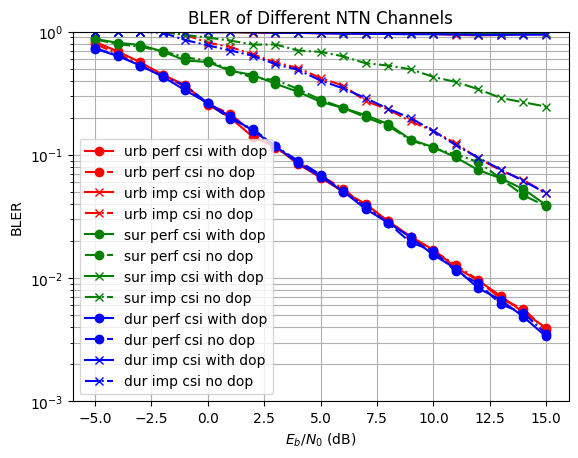

In [9]:
plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")

i=0
legend = []
for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        for doppler_enabled in SIMS["doppler_enabled"]:
            
            legend_str = ""

            if scenario=="urb":
                color = "red"
                legend_str+="urb "
            elif scenario=="dur":
                color = "b"
                legend_str+="dur "
            else:
                color = "g"
                legend_str+="sur "

            if perfect_csi:
                marker='o'
                legend_str+="perf csi "
            else:
                marker='x'
                legend_str+="imp csi "
            
            if doppler_enabled:
                linestyle="-"
                legend_str+="with dop"
            else:
                linestyle="-."
                legend_str+="no dop"


            plt.plot(SIMS["ebno_db"], SIMS["bler"][i], marker=marker, linestyle=linestyle,color=color)
            legend.append(legend_str)

            i += 1
plt.legend(legend)
plt.ylim([1e-3, 1])
plt.title("BLER of Different NTN Channels");
plt.yscale('log')

As we can see, the performance differ significantly. In the presence of Doppler, the systems were only able to function with perfect CSI. Without perfect CSI, the performance decreases rapidly.